<a href="https://colab.research.google.com/github/NdumbiData/Fraudulent-Transaction-Detection-for-Digital-Money-Transfer/blob/main/Modelling%20%26%20Hyparameter%20tuning%20%26%20SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Modelling of Nova Pay DataSet

In [5]:
# import dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Internship/Analysed_data_nova_pay_Combined.csv')
df.head(1)

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,day_of_week,is_weekend,ip_risk_score_count,night_hours,account_very_new,account_new,velocity_burst,amount_high,ip_high_risk,device_low_trust
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,us,USD,CAD,atm,278.19,278.19,4.25,...,0,0,low <0.3,1,0,0,0,0,0,0


In [6]:
df.columns

Index(['transaction_id', 'customer_id', 'timestamp', 'home_country',
       'source_currency', 'dest_currency', 'channel', 'amount_src',
       'amount_usd', 'fee', 'exchange_rate_src_to_dest', 'device_id',
       'new_device', 'ip_address', 'ip_country', 'location_mismatch',
       'ip_risk_score', 'kyc_tier', 'account_age_days', 'device_trust_score',
       'chargeback_history_count', 'risk_score_internal', 'txn_velocity_1h',
       'txn_velocity_24h', 'corridor_risk', 'is_fraud', 'hour', 'day_of_week',
       'is_weekend', 'ip_risk_score_count', 'night_hours', 'account_very_new',
       'account_new', 'velocity_burst', 'amount_high', 'ip_high_risk',
       'device_low_trust'],
      dtype='object')

In [7]:
# sort the dataframe chronologically by timestamp to avoid data leakage

df= df.sort_values(by='timestamp').reset_index(drop=True)


In [8]:
from pandas.core.arrays import categorical

categorical_features = ['channel','kyc_tier','home_country', 'dest_currency','ip_country']

numerical_features = ['amount_src', 'amount_usd', 'fee', 'ip_risk_score',
                      'device_trust_score','account_age_days','txn_velocity_1h',
                      'txn_velocity_24h', 'corridor_risk', 'risk_score_internal',
                      'hour','day_of_week','is_weekend','night_hours',
                      'account_very_new','account_new','velocity_burst',
                      'amount_high','ip_high_risk','device_low_trust',
                      'new_device', 'location_mismatch']

In [9]:
all_features = categorical_features + numerical_features

print(f"Total features : {len(all_features)}")
print(f'Categorical features : {len(categorical_features)}')
print(f'Numerical features : {len(numerical_features)}')
print(f'\nDastaset Shape: {df.shape}')

Total features : 27
Categorical features : 5
Numerical features : 22

Dastaset Shape: (11339, 37)


In [10]:
df[all_features]

,channel,kyc_tier,home_country,dest_currency,ip_country,amount_src,amount_usd,fee,ip_risk_score,device_trust_score,...,is_weekend,night_hours,account_very_new,account_new,velocity_burst,amount_high,ip_high_risk,device_low_trust,new_device,location_mismatch
0,atm,standard,us,CAD,US,278.19,278.19,4.25,0.123,0.522,...,0,1,0,0,0,0,0,0,False,False
1,web,standard,ca,MXN,CA,208.51,154.29,4.24,0.569,0.475,...,0,1,0,0,0,0,0,1,True,False
2,mobile,enhanced,us,CNY,US,160.33,160.33,2.70,0.437,0.939,...,0,1,0,0,0,0,0,0,False,False
3,mobile,standard,us,EUR,US,59.41,59.41,2.22,0.594,0.551,...,0,1,0,0,0,0,0,0,False,False
4,mobile,enhanced,us,INR,US,200.96,200.96,3.61,0.121,0.894,...,0,1,0,0,0,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11334,mobile,enhanced,us,CNY,US,335.76,335.76,6.67,0.246,0.939,...,0,1,0,0,0,0,0,0,False,False
11335,mobile,standard,us,MXN,US,429.26,429.26,7.64,0.315,0.372,...,1,1,0,0,1,0,0,1,True,False
11336,web,low,us,NGN,US,1214.16,1214.16,19.34,1.000,0.187,...,1,1,0,1,1,0,1,1,True,False
11337,web,standard,us,USD,UK,1044.46,1044.46,16.83,0.407,0.944,...,0,1,0,0,0,0,0,0,False,True


In [11]:
#split the data into 80% and 20% testing based on time

split_idx = int(len(df)*0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f'Train : {len(train_df)}) rows ({train_df['is_fraud'].sum()} fraud, {train_df['is_fraud'].mean():.3f} rate)')
print(f'Test : {len(test_df)} rows ({test_df['is_fraud'].sum()} fraud, {test_df['is_fraud'].mean():.3f} rate)')


#prepare x and y

x_train = train_df[all_features]
y_train = train_df['is_fraud']
x_test = test_df[all_features]
y_test = test_df['is_fraud']

print(f"Total features : {len(all_features)}")
print(f'Categorical features : {len(categorical_features)}')
print(f'Numerical features : {len(numerical_features)}')
print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

Train : 9071) rows (686 fraud, 0.076 rate)
Test : 2268 rows (309 fraud, 0.136 rate)
Total features : 27
Categorical features : 5
Numerical features : 22
x_train shape: (9071, 27), y_train shape: (9071,)
x_test shape: (2268, 27), y_test shape: (2268,)


In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# building processing pipelines

preprocesser = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop ="first" , sparse_output = False, handle_unknown ='ignore'),
         categorical_features)
    ]
)


# fit on train , transform both

x_train_processed = preprocesser.fit_transform(x_train)
x_test_processed = preprocesser.transform(x_test)

print(f'x_train_processed: {x_train_processed.shape}')
print (f'Original Features: {len(all_features)}, After encoding: {x_train_processed.shape[1]}')

x_train_processed: (9071, 48)
Original Features: 27, After encoding: 48


In [13]:
# import logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# train logistic regression with balanced weights

lr_model = LogisticRegression(class_weight='balanced', max_iter = 1000 , random_state=42)
lr_model.fit(x_train_processed, y_train)

#predicton test

y_pred = lr_model.predict(x_test_processed)
y_pred_proba = lr_model.predict_proba(x_test_processed)[:,1]

#evaluation

print('logistic Regression Results : ')
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names =["legit", "Fraud"]))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

logistic Regression Results : 

Confusion Matrix: 
[[1856  103]
 [  17  292]]

Classification Report: 
              precision    recall  f1-score   support

       legit       0.99      0.95      0.97      1959
       Fraud       0.74      0.94      0.83       309

    accuracy                           0.95      2268
   macro avg       0.87      0.95      0.90      2268
weighted avg       0.96      0.95      0.95      2268


ROC-AUC: 0.9816


In [14]:
from uuid import RFC_4122
# import Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Train Random forest classifier with balanced weights

rf_model = RandomForestClassifier(class_weight='balanced',
                                  n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  n_jobs =-1)
rf_model.fit(x_train_processed, y_train)

#prediction test
y_pred = rf_model.predict(x_test_processed)
y_pred_proba = rf_model.predict_proba(x_test_processed)[:,1]

#evaluation
print('Random Forest Results : ')
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names =["legit", "Fraud"]))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Random Forest Results : 

Confusion Matrix: 
[[1955    4]
 [  26  283]]

Classification Report: 
              precision    recall  f1-score   support

       legit       0.99      1.00      0.99      1959
       Fraud       0.99      0.92      0.95       309

    accuracy                           0.99      2268
   macro avg       0.99      0.96      0.97      2268
weighted avg       0.99      0.99      0.99      2268


ROC-AUC: 0.9738


In [15]:
# Import XGBoost

from xgboost import XGBClassifier

# Calculate scale_pos_weight for imbalance

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost classifier with balanced weights

xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight,
                          max_depth= 6,
                          learning_rate = 0.1,
                          random_state = 42,
                          eval_metric ="logloss"
)
xgb_model.fit(x_train_processed, y_train)

#predict on test
y_pred = xgb_model.predict(x_test_processed)
y_pred_proba = xgb_model.predict_proba(x_test_processed)[:,1]

#evaluation
print('XGBoost Results : ')
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names =["legit", "Fraud"]))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")



XGBoost Results : 

Confusion Matrix: 
[[1945   14]
 [  26  283]]

Classification Report: 
              precision    recall  f1-score   support

       legit       0.99      0.99      0.99      1959
       Fraud       0.95      0.92      0.93       309

    accuracy                           0.98      2268
   macro avg       0.97      0.95      0.96      2268
weighted avg       0.98      0.98      0.98      2268


ROC-AUC: 0.9642


In [16]:
# Import Lightgbm Classifier

from lightgbm import LGBMClassifier

#train LightGBM

lgbm_model = LGBMClassifier(
    n_estimators =100,
    max_depth = 6,
    learning_rate = 0.1,
    random_state = 42,
    class_weight = 'balanced',
    verbosity = -1
)

lgbm_model.fit(x_train_processed, y_train)

# predict on test
y_pred = lgbm_model.predict(x_test_processed)
y_pred_proba = lgbm_model.predict_proba(x_test_processed)[:,1]

#evaluation
print('LightGBM Results : ')
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names =["legit", "Fraud"]))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

LightGBM Results : 

Confusion Matrix: 
[[1935   24]
 [  26  283]]

Classification Report: 
              precision    recall  f1-score   support

       legit       0.99      0.99      0.99      1959
       Fraud       0.92      0.92      0.92       309

    accuracy                           0.98      2268
   macro avg       0.95      0.95      0.95      2268
weighted avg       0.98      0.98      0.98      2268


ROC-AUC: 0.9648


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Hyperameter Tuning

In [17]:
# Since we get the best results from Logistic regression , Lets fine tune it

# Import Grid Search

from sklearn.model_selection import GridSearchCV

# Base model
lr_model_tuned = LogisticRegression(max_iter=1000, random_state=42)

# Parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],  # supports l1 + l2
    "class_weight": [None, "balanced"]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=lr_model_tuned,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(x_train_processed, y_train)

# Best model
best_lr_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [18]:
# Evaluate the results

y_pred = best_lr_model.predict(x_test_processed)
y_pred_proba = best_lr_model.predict_proba(x_test_processed)[:, 1]

print("\n========== Tuned Logistic Regression Results ==========")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Legit", "Fraud"]))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


========== Tuned Logistic Regression Results ==========

Confusion Matrix:
[[1870   89]
 [  18  291]]

Classification Report:
              precision    recall  f1-score   support

       Legit       0.99      0.95      0.97      1959
       Fraud       0.77      0.94      0.84       309

    accuracy                           0.95      2268
   macro avg       0.88      0.95      0.91      2268
weighted avg       0.96      0.95      0.95      2268


ROC-AUC: 0.9829


In [19]:
# Random forest hyperameter tuning

# import randomized search vc

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


print ('Starting Random Forest Hyperameter Tuning ...\n')

#parameter Grid

param_dist = {
    'n_estimators' : [100,200,300],
    "max_depth" : [10, 10,30,None],
    "min_samples_split" :  [2,5,10],
    "min_samples_leaf" : [1,2,4],
    "max_features" : ["sqrt", "log2"],
    "class_weight" : ["balanced"]
}

# RandomizedSearchCV

rf_tuned = RandomizedSearchCV(
    RandomForestClassifier(random_state = 42),
    param_distributions = param_dist,
    n_iter = 25,
    scoring = 'f1',
    n_jobs = -1,
    cv = 3,
    random_state = 42,
    verbose = 1
)

rf_tuned.fit(x_train_processed, y_train)

print(f'Best parameters: {rf_tuned.best_params_}')

for param, value in rf_tuned.best_params_.items():
    print(f'{param}: {value}')


print(f'\nBest CV F1-score: {rf_tuned.best_score_:.4f}')



Starting Random Forest Hyperameter Tuning ...

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced'}
n_estimators: 200
min_samples_split: 2
min_samples_leaf: 1
max_features: log2
max_depth: None
class_weight: balanced

Best CV F1-score: 0.8499


In [20]:
#evaluate the tuned model on test set

y_pred_tuned = rf_tuned.predict(x_test_processed)
y_pred_proba_tuned = rf_tuned.predict_proba(x_test_processed)


print("="*60)
print('Tuned Random Forest Results : ')
print("="*60)
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report: ")
print(classification_report(y_test, y_pred_tuned,
                            target_names =["legit", "Fraud"]))

roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f'ROC-AUC (Tuned): {roc_auc_tuned:.4f}')


Tuned Random Forest Results : 

Confusion Matrix: 
[[1870   89]
 [  18  291]]

Classification Report: 
              precision    recall  f1-score   support

       legit       0.99      1.00      0.99      1959
       Fraud       1.00      0.92      0.95       309

    accuracy                           0.99      2268
   macro avg       0.99      0.96      0.97      2268
weighted avg       0.99      0.99      0.99      2268


ROC-AUC: 0.9829
ROC-AUC (Tuned): 0.9719


Best results are from logistic regression and Random Forest


In [21]:
#Cross validation for confirmation on the best model.

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import pandas as pd # Ensure pandas is imported for DataFrame operations

models = {
    "Logistic Regression": best_lr_model,
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

cv_results = {}

# Define Stratified K-Fold cross-validation
# The number of splits (n_splits) is set to 10 to match the previous cv=10
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_validate(
        model,
        x_train_processed,
        y_train,
        cv=skf, # Use the stratified k-fold object here
        scoring=scoring,
        n_jobs=-1
    )

    cv_results[name] = {
        metric: scores[f"test_{metric}"].mean()
        for metric in scoring
    }

cv_df = pd.DataFrame(cv_results).T
display(cv_df.sort_values("roc_auc", ascending=False))

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.941242,0.582998,0.823361,0.680273,0.938599
Gradient Boosting,0.979605,0.966808,0.756513,0.847320,0.936202
Random Forest,0.981478,0.994558,0.759454,0.859661,0.926912


Both Models are effective in modeling

*  Logistic Regression which has the highest recall


Confirmed with the cross Validation.




Save Models

In [22]:
output_path = '/content/drive/MyDrive/Data Science Internship/Modelled_data_nova_pay_Combined.csv'
df.to_csv(output_path, index=False)

In [23]:
import joblib

# Save Logistic Regression
joblib.dump(best_lr_model, 'logistic_regression.joblib')


['logistic_regression.joblib']

In [24]:
# Save Random Forest
joblib.dump(rf_model, 'random_forest.joblib')

['random_forest.joblib']

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Save in my Google Drive
save_path = '/content/drive/MyDrive/Data Science Internship/Models /Nova Pay Project Models /Random Forest'

joblib.dump(best_lr_model, save_path + 'logistic_regression.joblib')

['/content/drive/MyDrive/Data Science Internship/Models /Nova Pay Project Models /Random Forestlogistic_regression.joblib']

In [27]:
# Export Logreg into an external storage
import shutil
import os

# Save the best_lr_model locally
joblib.dump(best_lr_model, 'logistic_regression.joblib')

# Define the destination path in Google Drive
destination_path_lr = '/content/drive/MyDrive/Data Science Internship/Models/Nova Pay Project Models/Logistic Regression/logistic_regression.joblib'

# Ensure the destination directory exists
os.makedirs(os.path.dirname(destination_path_lr), exist_ok=True)

# Move the locally saved file to Google Drive
shutil.move('logistic_regression.joblib', destination_path_lr)

print(f"Tuned Logistic Regression model saved to: {destination_path_lr}")

Tuned Logistic Regression model saved to: /content/drive/MyDrive/Data Science Internship/Models/Nova Pay Project Models/Logistic Regression/logistic_regression.joblib


## SHAP( SHapley Additive exPlanations)


Lets know which features have most importance for stakeholder Explanability.


In [31]:
## SHAP( SHapley Additive exPlanations)


#Lets know which features have most importance for stakeholder Explanability.

import shap



In [32]:
# Lets create SHAP explainer for random forest

explainer_rf = shap.TreeExplainer(rf_model)

#Calculate SHAP values for the test set ( sample 100 for speed)

shap_values_rf = explainer_rf.shap_values(x_test_processed[:100])

print(f'Shap Values Shape: {shap_values_rf.shape}')
print("Explainer ready for Random Forest")


Shap Values Shape: (100, 48, 2)
Explainer ready for Random Forest


In [33]:
# Getting feature names after preprocessing

catshap_features =preprocesser.named_transformers_['cat'].get_feature_names_out(categorical_features)

numshap_features = numerical_features

shap_features = np.concatenate([catshap_features, numshap_features])

print(f' Total features after encoding: {len(shap_features)}')
print("First 10 features: (",shap_features[:10],")")

 Total features after encoding: 48
First 10 features: ( ['channel_mobile' 'channel_unknown' 'channel_web' 'kyc_tier_low'
 'kyc_tier_standard' 'kyc_tier_unknown' 'kyc_tier_nan' 'home_country_uk'
 'home_country_unknown' 'home_country_us'] )


In [34]:
# Interprating SHAP values for fraud values

# Extract SHAP values (class 1)

shap_values_fraud  = shap_values_rf[:,:,1]

# Calculate mean absolute SHAP values
mean_shap = np.abs(shap_values_fraud).mean(axis=0)

# create feature importance dataframe

feature_importance_df = pd.DataFrame({
    'feature': shap_features,
    'importance': mean_shap
}).sort_values(by='importance', ascending=False)

print("\nTop 15 Most important Features: ")
print(feature_importance_df.head(15).to_string(index=False))




Top 15 Most important Features: 
           feature  importance
  kyc_tier_unknown    0.054698
   home_country_us    0.053606
      kyc_tier_low    0.046955
   home_country_uk    0.046353
 dest_currency_PHP    0.044496
      kyc_tier_nan    0.041390
 kyc_tier_standard    0.024334
  ip_country_ US      0.020613
    channel_mobile    0.019238
  ip_country_ UK      0.017872
 dest_currency_MXN    0.017823
       channel_web    0.017046
ip_country_unknown    0.012726
   channel_unknown    0.012397
     ip_country_CA    0.010774


Text(0.5, 1.0, 'Top 15 Most Important Features')

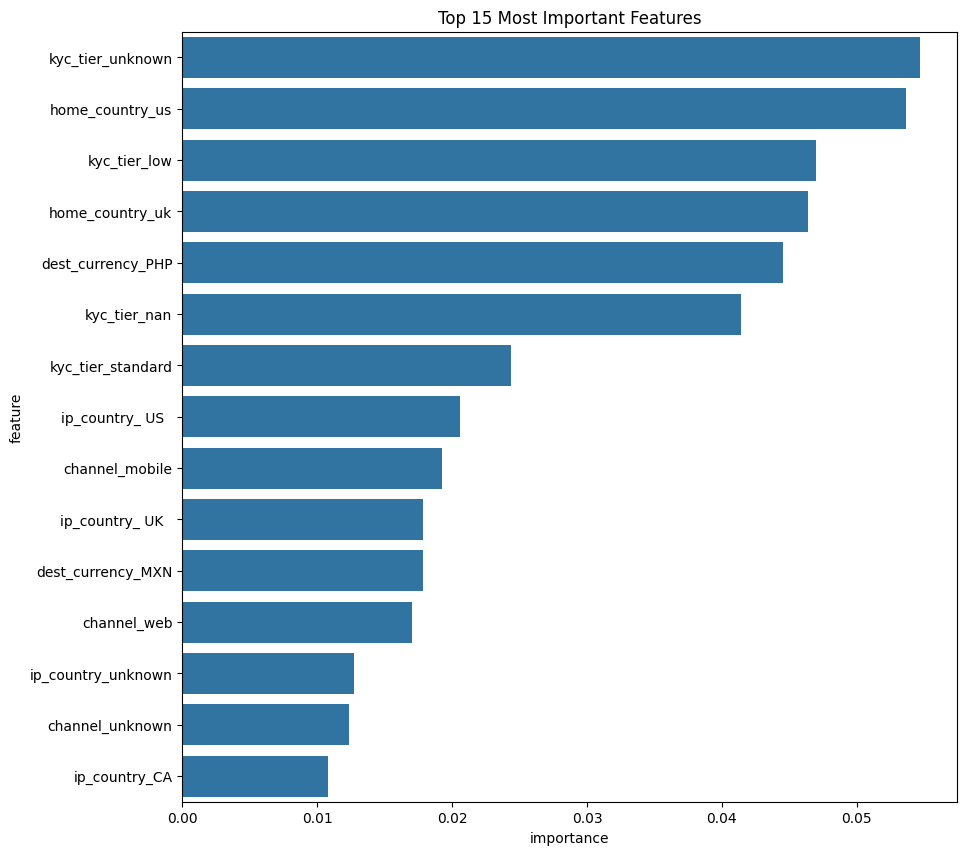

In [35]:
# Plot top 15 feature importance

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features')

In [36]:
# Create a transcation explainer function

def explain_transaction(idx, model, shap_values, x_test, y_test, features_names):
#Helps generate explanation for each trasaction

  true_label = "Fraud" if y_test.iloc[idx] == 1 else "legitimate"
  pred_proba = model.predict_proba(x_test[idx:idx+1])[0,1]
  prediction = "Fraud" if pred_proba > 0.5 else "legitimate"

  # get shap Values for this sample
  shap_vals = shap_values [idx]
  feature_vals = x_test[idx]

  # get top contributing features
  contributions = list(zip(features_names, feature_vals, shap_vals))
  contributions.sort(key=lambda x: abs(x[1]), reverse=True)

  # separate positive and negative contributors

  risk_factors = [c for c in contributions if c[2] > 0][:5]
  protective_factors = [c for c in contributions if c[2] < 0][:5]

  explanation = f"""

  Transaction Explanation

  ======================================================
  Transcation ID : Test Sample # {idx}
  True Label: {true_label}
  Predicted Label: {prediction}
  Predicted Probability Confidence : {pred_proba:.1%}

  Top Risk Factors (Increase Fraud Risk:)"""

  for feat , val,  shap_val in risk_factors:
            explanation +=f"  . {feat} : {val:.3f} ({shap_val:.3f}) \n"

            explanation += ("f\nTop protective factors (Decrease Fraud Risk):\n")
  for feat, val, shap_val in protective_factors:
                explanation += (f"  . {feat} : {val:.3f} ({shap_val:.3f})\n")

  return explanation
print('Function Defined')



Function Defined


In [37]:
def explain_transaction(idx, model, shap_values, x_test, y_test, features_names):

    true_label = "Fraud" if y_test.iloc[idx] == 1 else "Legitimate"

    pred_proba = model.predict_proba(x_test[idx:idx+1])[0,1]
    prediction = "Fraud" if pred_proba > 0.5 else "Legitimate"

    shap_vals = shap_values[idx]
    feature_vals = x_test[idx]

    contributions = list(zip(features_names, feature_vals, shap_vals))
    contributions.sort(key=lambda x: abs(x[2]), reverse=True)

    risk_factors = [c for c in contributions if c[2] > 0][:5]
    protective_factors = [c for c in contributions if c[2] < 0][:5]

    explanation = f"""
Transaction Explanation
======================================================
Transaction ID: Test Sample #{idx}
True Label: {true_label}
Predicted Label: {prediction}
Predicted Probability Confidence: {pred_proba:.1%}

Top Risk Factors (Increase Fraud Risk):
"""

    # Print risk factors
    for feat, val, shap_val in risk_factors:
        explanation += f"  • {feat}: {val:.3f} (SHAP: {shap_val:.3f})\n"

    # Add protective header ONCE (outside loop)
    explanation += "\nTop Protective Factors (Decrease Fraud Risk):\n"

    # Print protective factors
    for feat, val, shap_val in protective_factors:
        explanation += f"  • {feat}: {val:.3f} (SHAP: {shap_val:.3f})\n"

    return explanation

In [38]:

import random
import numpy as np

# Number of rows available in SHAP values
shap_sample_size = shap_values_fraud.shape[0]

# Fraud indices only within SHAP range
fraud_indices_shap = np.where(y_test[:shap_sample_size] == 1)[0]

# Pick a random fraud index from SHAP-computed rows
random_fraud_idx = random.choice(fraud_indices_shap)

print(f"Random fraud test sample (within SHAP range): {random_fraud_idx}")

# Show original data row
original_row_idx = test_df.index[random_fraud_idx]
print("\nOriginal transaction data:")
print(test_df.loc[original_row_idx])

print(explain_transaction(
    random_fraud_idx,
    rf_model,
    shap_values_fraud,
    x_test_processed[:shap_sample_size],
    y_test[:shap_sample_size],
    shap_features
))

Random fraud test sample (within SHAP range): 41

Original transaction data:
transaction_id               f83be117-6a1d-4041-81d4-9f9907980527
customer_id                  0c8916bd-b85b-4042-a239-46c4a5f9091b
timestamp                        2025-03-27 12:10:02.573611+00:00
home_country                                                   ca
source_currency                                               CAD
dest_currency                                                 INR
channel                                                       web
amount_src                                                 227.26
amount_usd                                                 168.17
fee                                                          4.92
exchange_rate_src_to_dest                               61.666667
device_id                    1c3816b9-8616-4189-8a2c-bed0aa6abc9b
new_device                                                  False
ip_address                                           15.62.78.243